In [1]:
import numpy as np
import xarray as xr
import warnings
from pandas import date_range
from pathlib import Path

from grid_toolbox.basic_latlon import get_cells_area

import pycompo.core.composite as pccompo
import pycompo.core.coord as pccoord
import pycompo.core.ellipse as pcellipse
import pycompo.core.feature_cutout as pcfeatcut
import pycompo.core.filter as pcfilter
import pycompo.core.plot as pcplot
import pycompo.core.sigtest as pcsig
import pycompo.core.sst_features as pcsst
import pycompo.core.wind as pcwind
import pycompo.core.utils as pcutil

warnings.filterwarnings(action='ignore')

# read in configuration file
config_file = "/home/m/m300738/libs/pycompo/config/settings_template.yaml"
#config_file = "/home/m/m300738/libs/pycompo/config/settings_ngc5004_pc14.yaml"
config = pcutil.read_yaml_config(config_file)

start_time = config['data']['analysis_time'][0]
end_time = config['data']['analysis_time'][1]
analysis_times = [
    np.datetime64(t) for t in date_range(
        np.datetime64(start_time), np.datetime64(end_time), freq='MS',
        )
    ]
feature_var = config['data']['feature_var']
varlist = [feature_var] + config['data']['wind_vars'] + \
    config['data']['study_vars']

### Read in data, building SST anomalies and their gradients using Gaussian filter

In [5]:
infiles = []
for var in varlist:
    inpath = Path(config['data']['inpaths'][var])
    in_pattern = f"{config['exp']}_tropical_{var}_*.nc"
    infiles.extend(sorted([str(f) for f in inpath.rglob(in_pattern)]))
dset = xr.open_mfdataset(infiles, parallel=False).squeeze()
dset = pcutil.subsample_data(dset, start_time, end_time, config)
if config['test']: dset = dset.isel(time=slice(20, 22))
if 'height_2' in dset.coords: dset = dset.drop('height_2')

# Detrend data with climatology
if config['detrend']['switch']:
    dset, feature_var, varlist = pcfilter.detrend_with_hourly_climatology(
        dset, feature_var, config,
        )

for var in varlist: dset[var] = dset[var].compute()

# scale separation
filter_vars = [feature_var] + config['data']['wind_vars']
if config['composite']['type'] == 'anomaly':
    filter_vars += config['data']['study_vars']
dset_filter = pcfilter.get_gaussian_filter_bg_ano(
    dset[filter_vars], **config['filter']
    )

if config['composite']['type'] == 'anomaly':
    merge_dsets = [
        dset_filter[[f"{var}_bg" for var in config['data']['wind_vars']]],
        dset_filter[[f"{var}_ano" for var in filter_vars]],
        ]
    grad_var = f"{feature_var}_ano"
elif config['composite']['type'] == 'absolute':
    merge_dsets = [
        dset_filter[[f"{var}_bg" for var in config['data']['wind_vars']]],
        dset_filter[f"{feature_var}_ano"],
        dset,
        ]
    grad_var = feature_var

# calculate stability proxy if input variables are available
if 'ts_bg' in dset_filter and 'tas_bg' in dset_filter:
    dset_filter['tas-ts_bg'] = dset_filter['tas_bg'] - dset_filter['ts_bg']
    merge_dsets.append(dset_filter['tas-ts_bg'])
if 'sfc_rho_bg' in dset_filter:
    merge_dsets.append(dset_filter['sfc_rho_bg'])
if 'pr_bg' in dset_filter:
    merge_dsets.append(dset_filter['pr_bg'])

dset = xr.merge(merge_dsets)

# add timelag, calculate gradients, and subsampling
dset = pcutil.add_timelag_idx_space(
    dset, f"{feature_var}_ano", config['data']['timelag_idx'],
    )
dset = pccoord.calc_sphere_gradient_laplacian(dset, grad_var)
if 'ps' in config['data']['study_vars']:
    if config['composite']['type'] == 'anomaly':
        dset = pccoord.calc_sphere_laplacian(dset, 'ps_ano')
    elif config['composite']['type'] == 'absolute':
        dset = pccoord.calc_sphere_laplacian(dset, 'ps')

dset['cell_area'] = get_cells_area(dset)
dset = dset.sel(lat=slice(*config['lat_range']), drop=True)

# calculate population mean for correct Null hypothesis in significance testing
popmeans_alltrops = pcsig.calc_popmeans(dset, feature_var)
popmeans_alltrops = popmeans_alltrops.mean(dim='time')

if config['composite']['rainbelt_subsampling']['switch']:
    rainbelt = pccompo.get_rainbelt(analysis_times, config, quantile=0.8)
    if config['test']: rainbelt = rainbelt.isel(time=slice(20, 22))
    rainbelt = rainbelt.compute()
    popmeans_rainbelt = pcsig.calc_popmeans(dset.where(rainbelt), feature_var)
    popmeans_rainbelt = popmeans_rainbelt.mean(dim='time')

orig_coords = pccoord.get_coords_orig(dset.drop('time'))

### Detection of SST clusters and cutout of corresponding data

In [ ]:
dset[f"{feature_var}_feature"], feature_props = pcsst.extract_sst_features(
    dset[f"{feature_var}_ano_detect"], **config['feature'],
    )
dset, feature_props, feature_data = pcfeatcut.get_featcen_data_cutouts(
    dset, feature_props, feature_var, config['cutout']['search_RadRatio'],
    )
feature_props = pcwind.calc_feature_bg_wind(
    feature_props, feature_data, config['data']['wind_vars'],
    )
feature_props = pcsst.add_more_feature_props(
    feature_props, feature_data, orig_coords,
    )

In [12]:

# coordinate transformation
feature_ellipse = pcellipse.get_ellipse_params(feature_props, orig_coords)
feature_data = pccoord.add_featcen_coords(
    orig_coords, feature_data, feature_props, feature_ellipse,
    )
feature_data = pcwind.add_wind_grads(feature_data, feature_props, grad_var)
feature_data = pcwind.add_rotate_winds(feature_data, feature_props)
feature_compo_data = pccompo.get_compo_coords_ds(feature_data, config)

# Significance tests
_, pvalue = pcsig.calc_compo_ttest(
    feature_compo_data, popmean=popmeans_alltrops,
    )
local_significane = pcsig.get_local_significance(pvalue, alpha=0.05)
field_significane = pcsig.get_field_significance(pvalue, alpha_FDR=0.1)

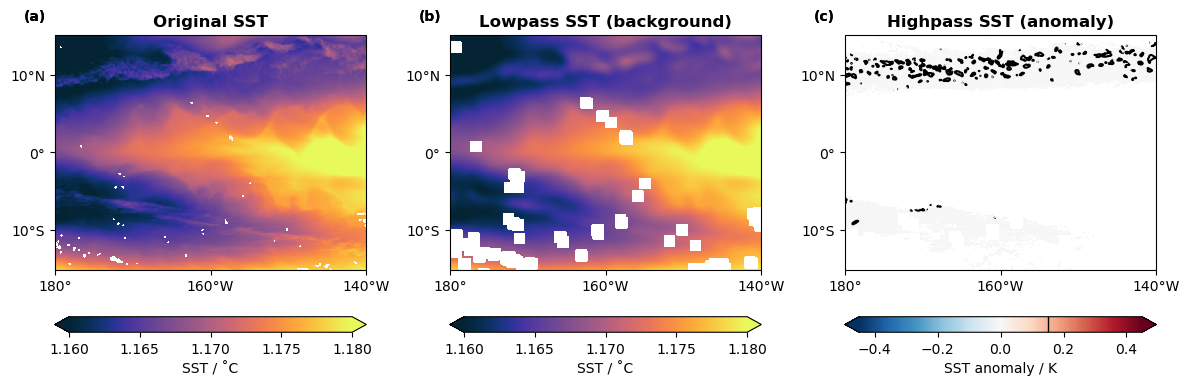

In [10]:
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import cartopy.mpl.ticker as tck
import hfplot.figure.figure as hffig

# User settings of spatiotemporal plotting area
lat_slice = slice(0, 10)
lat_slice = slice(-15, 15)
lon_slice = slice(-170, -160)
lon_slice = slice(-180, -140)
time_index = 0
threshold = config['feature']['threshold']

_, axs = hffig.init_subfig(
    style=None, asprat=(12, 5), nrow=1, ncol=3, sharex=True,
    proj=ccrs.Mercator(central_longitude=-160)
    )

ano_range = (-3 * threshold, 3 * threshold)
ano_cmap = 'RdBu_r'

dset_plot = dset_filter.isel(time=time_index).sel(lat=lat_slice, lon=lon_slice)
rainbelt_plot = rainbelt.isel(time=time_index).sel(lat=lat_slice, lon=lon_slice)
# filled contour plots
(dset_plot['sfc_rho']).plot(
    ax=axs[0, 0], vmin=1.16, vmax=1.18, cmap=cmocean.cm.thermal, extend='both',
    cbar_kwargs={'orientation': 'horizontal', 'label': 'SST / ˚C', 'pad': 0.1},
    transform=ccrs.PlateCarree(),
    ) # type: ignore
axs[0, 0].set_title('Original SST', weight='bold')

(dset_plot[f'sfc_rho_bg']).plot(
    ax=axs[0, 1], vmin=1.16, vmax=1.18, cmap=cmocean.cm.thermal, extend='both',
    cbar_kwargs={'orientation': 'horizontal', 'label': 'SST / ˚C', 'pad': 0.1},
    transform=ccrs.PlateCarree(),
    ) # type: ignore
axs[0, 1].set_title('Lowpass SST (background)', weight='bold')

im = dset_plot[f'sfc_rho_ano'].where(rainbelt_plot).plot(
    ax=axs[0, 2], vmin=ano_range[0], vmax=ano_range[1], cmap=ano_cmap,
    extend='both', cbar_kwargs={'orientation': 'horizontal', 'label': 'SST anomaly / K', 'pad': 0.1},
    transform=ccrs.PlateCarree(),
    ) # type: ignore
cbar = im.colorbar
cbar.ax.axvline(0.15, color='k', linewidth=1) 
axs[0, 2].set_title('Highpass SST (anomaly)', weight='bold')

# overlay contour lines for anomalies
axs[0, 2].contour(
    dset_plot['lon'], dset_plot['lat'], dset_plot[f'ts_ano'].where(rainbelt_plot),
    levels=[threshold], colors='k', transform=ccrs.PlateCarree()
    )

for i in range(0, 3):
    axs[0, i].set_xticks(np.arange(-180, -139, 20), crs=ccrs.PlateCarree())
    axs[0, i].set_yticks(np.arange(-10, 11, 10), crs=ccrs.PlateCarree())

    axs[0, i].xaxis.set_major_formatter(tck.LongitudeFormatter())
    axs[0, i].yaxis.set_major_formatter(tck.LatitudeFormatter())

    axs[0, i].set_xlabel(None)
    axs[0, i].set_ylabel(None)

axs[0, 0].text(-0.1, 1.05, f"(a)", transform=axs[0, 0].transAxes, fontweight="bold", ha='left', va='bottom')
axs[0, 1].text(-0.1, 1.05, f"(b)", transform=axs[0, 1].transAxes, fontweight="bold", ha='left', va='bottom')
axs[0, 2].text(-0.1, 1.05, f"(c)", transform=axs[0, 2].transAxes, fontweight="bold", ha='left', va='bottom')

plt.tight_layout()
plt.show()

### Visualization

#### SST preprocessing steps

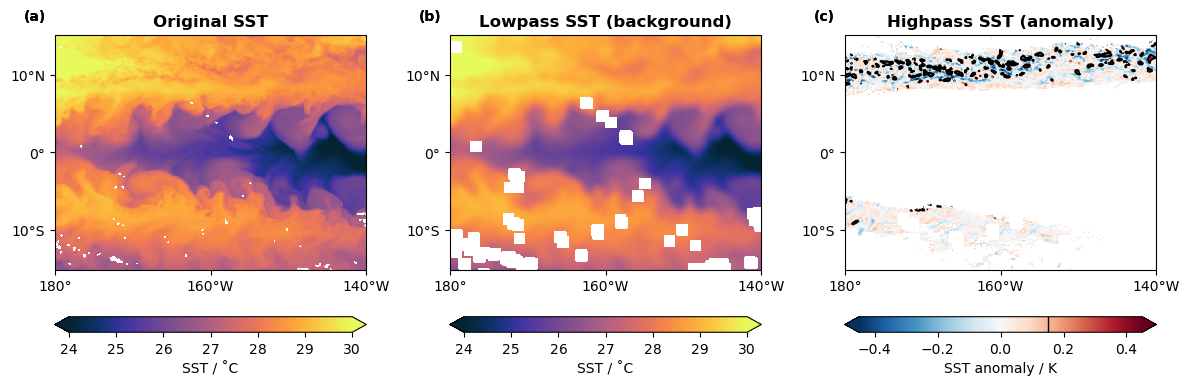

In [ ]:
import matplotlib.pyplot as plt
import cmocean
import cartopy.crs as ccrs
import cartopy.mpl.ticker as tck
import hfplot.figure.figure as hffig

# User settings of spatiotemporal plotting area
lat_slice = slice(0, 10)
lat_slice = slice(-15, 15)
lon_slice = slice(-170, -160)
lon_slice = slice(-180, -140)
time_index = 0
threshold = config['feature']['threshold']

_, axs = hffig.init_subfig(
    style=None, asprat=(12, 5), nrow=1, ncol=3, sharex=True,
    proj=ccrs.Mercator(central_longitude=-160)
    )

ano_range = (-3 * threshold, 3 * threshold)
ano_cmap = 'RdBu_r'

dset_plot = dset_filter.isel(time=time_index).sel(lat=lat_slice, lon=lon_slice)
rainbelt_plot = rainbelt.isel(time=time_index).sel(lat=lat_slice, lon=lon_slice)
# filled contour plots
(dset_plot['ts']-273.15).plot(
    ax=axs[0, 0], vmin=24, vmax=30, cmap=cmocean.cm.thermal, extend='both',
    cbar_kwargs={'orientation': 'horizontal', 'label': 'SST / ˚C', 'pad': 0.1},
    transform=ccrs.PlateCarree(),
    ) # type: ignore
axs[0, 0].set_title('Original SST', weight='bold')

(dset_plot[f'ts_bg']-273.15).plot(
    ax=axs[0, 1], vmin=24, vmax=30, cmap=cmocean.cm.thermal, extend='both',
    cbar_kwargs={'orientation': 'horizontal', 'label': 'SST / ˚C', 'pad': 0.1},
    transform=ccrs.PlateCarree(),
    ) # type: ignore
axs[0, 1].set_title('Lowpass SST (background)', weight='bold')

im = dset_plot[f'ts_ano'].where(rainbelt_plot).plot(
    ax=axs[0, 2], vmin=ano_range[0], vmax=ano_range[1], cmap=ano_cmap,
    extend='both', cbar_kwargs={'orientation': 'horizontal', 'label': 'SST anomaly / K', 'pad': 0.1},
    transform=ccrs.PlateCarree(),
    ) # type: ignore
cbar = im.colorbar
cbar.ax.axvline(0.15, color='k', linewidth=1) 
axs[0, 2].set_title('Highpass SST (anomaly)', weight='bold')

# overlay contour lines for anomalies
axs[0, 2].contour(
    dset_plot['lon'], dset_plot['lat'], dset_plot[f'ts_ano'].where(rainbelt_plot),
    levels=[threshold], colors='k', transform=ccrs.PlateCarree()
    )

for i in range(0, 3):
#    axs[0, i].contour(
#        dset_plot['lon'], dset_plot['lat'], dset_plot[f'ts_ano'],
#        levels=[threshold], colors='k', transform=ccrs.PlateCarree()
#        )
    axs[0, i].set_xticks(np.arange(-180, -139, 20), crs=ccrs.PlateCarree())
    axs[0, i].set_yticks(np.arange(-10, 11, 10), crs=ccrs.PlateCarree())

    axs[0, i].xaxis.set_major_formatter(tck.LongitudeFormatter())
    axs[0, i].yaxis.set_major_formatter(tck.LatitudeFormatter())

    axs[0, i].set_xlabel(None)
    axs[0, i].set_ylabel(None)

axs[0, 0].text(-0.1, 1.05, f"(a)", transform=axs[0, 0].transAxes, fontweight="bold", ha='left', va='bottom')
axs[0, 1].text(-0.1, 1.05, f"(b)", transform=axs[0, 1].transAxes, fontweight="bold", ha='left', va='bottom')
axs[0, 2].text(-0.1, 1.05, f"(c)", transform=axs[0, 2].transAxes, fontweight="bold", ha='left', va='bottom')

plt.tight_layout()
outpath = Path(
    f'/home/m/m300738/project_TRR181L4/plots/sst_feature_composites/'
    )
outpath.mkdir(parents=True, exist_ok=True)
outfile = Path(f'visualization_bandpass_rb.png')
plt.savefig(str(outpath/outfile), dpi=600)
plt.show()

In [8]:
if config['detrend']['switch']:
    # User settings of spatiotemporal plotting area
    lat_slice = slice(0, 10)
    lat_slice = slice(-15, 15)
    lon_slice = slice(-170, -160)
    lon_slice = slice(-179, -140)
    time_index = 0

    pcplot.plot_preprocessing_overview_map(
        dset.isel(time=time_index).sel(lat=lat_slice, lon=lon_slice),
        feature_var, config['feature']['threshold'], 
        )

#### Remapping

In [ ]:
feature_id = 103 #38
wind = feature_props[['bg_uas', 'bg_vas']]
pcplot.plot_coord_trafo(
    feature_data, feature_ellipse, wind, feature_id,
    f"{feature_var}_ano", config['feature']['threshold'],
    )

#### Plain composites

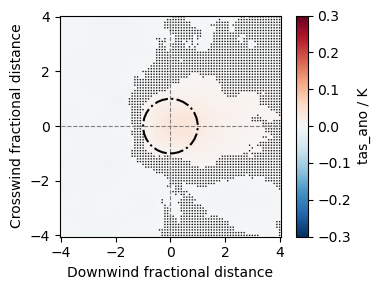

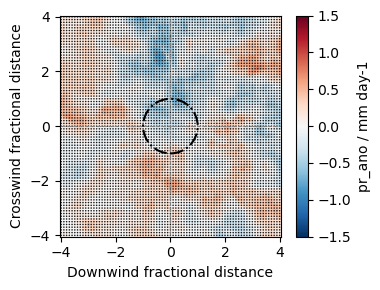

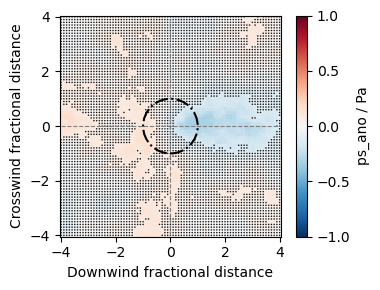

In [ ]:
import importlib as implib
implib.reload(pcplot)

for var in config['data']['study_vars']:
    plot_ds = pccompo.adjust_units(feature_compo_data, [f'{var}_ano'])
    plot_ds = plot_ds[f'{var}_ano'].mean(dim='feature')
    if plot_ds.ndim != 2:
        continue
    pcplot.plot_composite(plot_ds, field_significane[f'{var}_ano'])

In [ ]:
import importlib as implib
implib.reload(pcplot)

vars = [
    'ts_ano', 'downwind_ts_ano_grad', 'ts_ano_laplacian', 'hfls_ano', 'pr_ano',
    'ps_ano', 'tas_ano', 'sfcwind_ano', 'sfcwind_conv_ano',
    ]

pcplot.plot_composite_overview(
    pccompo.adjust_units(feature_compo_data.mean(dim='feature'), vars),
    field_significane, vars,
    )